# Second Project Work Week Assignment
### Authors: Dan Davieau, Paul Panek, Olga Tanyuk, Nathan Wall

### Initial Data Prep

For the purpose of this assignment we view the data prep as conditional to the specific classification task. However, there are several minor data cleaning tasks that are applicable to either task and are performed in the code below

In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv('DefaultCreditcardClients.csv')
df.rename(columns={'default payment next month':'default'}, inplace=True)

#set index to the "ID" value and remove the ID column
df.index = df.ID
del df['ID']

#Create Lists for Analysis
continuous_features = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3',
                       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                       'PAY_AMT6']
ordinal_features = ['EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0','PAY_2', 'PAY_3',
                    'PAY_4', 'PAY_5', 'PAY_6','default']

#Convert datatypes
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)

#convert any non-identified education categories to 'OTHER'
df['EDUCATION'] = df['EDUCATION'].replace(to_replace=(0,5,6),value=4)

#convert any non-identified marriage categories to 'OTHER'
df['MARRIAGE'] = df['MARRIAGE'].replace(to_replace=(0),value=3)

#Log transform continuous variables; as they each have a mostly 
##exponential distribution
df["log_LIMIT_BAL"]=np.log(df.LIMIT_BAL)
df["log_PAY_AMT1"]=np.log(df.PAY_AMT1+1)
df["log_PAY_AMT2"]=np.log(df.PAY_AMT2+1)
df["log_PAY_AMT3"]=np.log(df.PAY_AMT3+1)
df["log_PAY_AMT4"]=np.log(df.PAY_AMT4+1)
df["log_PAY_AMT5"]=np.log(df.PAY_AMT5+1)
df["log_PAY_AMT6"]=np.log(df.PAY_AMT6+1)
df["log_BILL_AMT1"]=np.log(df.BILL_AMT1.abs()+1)
df["log_BILL_AMT2"]=np.log(df.BILL_AMT2.abs()+1)
df["log_BILL_AMT3"]=np.log(df.BILL_AMT3.abs()+1)
df["log_BILL_AMT4"]=np.log(df.BILL_AMT4.abs()+1)
df["log_BILL_AMT5"]=np.log(df.BILL_AMT5.abs()+1)
df["log_BILL_AMT6"]=np.log(df.BILL_AMT6.abs()+1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 37 columns):
LIMIT_BAL        30000 non-null float64
SEX              30000 non-null int64
EDUCATION        30000 non-null int64
MARRIAGE         30000 non-null int64
AGE              30000 non-null int64
PAY_0            30000 non-null int64
PAY_2            30000 non-null int64
PAY_3            30000 non-null int64
PAY_4            30000 non-null int64
PAY_5            30000 non-null int64
PAY_6            30000 non-null int64
BILL_AMT1        30000 non-null float64
BILL_AMT2        30000 non-null float64
BILL_AMT3        30000 non-null float64
BILL_AMT4        30000 non-null float64
BILL_AMT5        30000 non-null float64
BILL_AMT6        30000 non-null float64
PAY_AMT1         30000 non-null float64
PAY_AMT2         30000 non-null float64
PAY_AMT3         30000 non-null float64
PAY_AMT4         30000 non-null float64
PAY_AMT5         30000 non-null float64
PAY_AMT6         30000 non-null

# Predicting Customer "Default"
The first portion of the report we will explore various models to try and classify customer's likelihood of default.

### Modeling & Evaluation Considerations

Part 1)
For this particular classification model we will assessing our models based on their F1 scores.

A client may use this model to determine which customer-facing strategies to deploy for a given customer. If a customer is expected to default, there should be a more intesive collection strategy, and management of credit lines should be more conservative. While such strategies are designed to limit losses from defaults, they may also lead to sub-optimal customer experiences for those who do not default. Customers who are treated as likely to default are expected to attrit if they do not default.

Precision is therefore important. Low precision would lead to higher customer attrition. Recall is also important. Low Recall represents missed opportunity to apply loss-mitigation strategies to customer who need them, and will result in high default costs.

Since balancing these two factors is important, we will choose F1 as the evaluation metric for this suite of models.

Part 2)
In order to effectively evaluate our model performance we will splitting our data into training & test sets using an initial 80/20 split. Additionally, due to the class imbalance between default customers and non-default customers we will be oversampling default customers in our training data. If left unbalanced our model will bias towards assuming most customers will not default. This is a costly bias as described above. In order to overcome that limitation we will provide the classifiers more examples of default by sampling from replacement from our positive cases. This will likely lower our overall accuracy but will improve our 

### Data Preperation - Default Classification Specific
Below we perform several steps that explain some of the data preparation tasks that are specific to the goal of classifying customers default on credit card payments.

First we remove the variables that we identified as not important from Lab1 & Mini-Lab1. We also one hot encode our categorical features for use in our models. Below you will find the fields that are considered in our model.

Field Definitions:
- The items in the final data set are shown below.
- Monetary amounts are in New Taiwanese dollars
- SEX
    * 1 = Male
    * 2 = Female
- AGE = Credit Card holder age in years
- default: Whether or not the customer defaulted (Target for predicting default)
- Payment history (2005)
- PAY_0 = September
- PAY_2 = August
- PAY_3 = July
- PAY_4 = June
- PAY_5 = May
- PAY_6 = April
-1 = payment received on time
    - 1 = payment received one month late
    - 2 = payment received two months late
    - 9 = payment received nine months late or more
- log_LIMIT_BAL: Natural log of the Credit Limit (max amount of credit allowed)
- log_PAY_AMT: Natural log of the amount paid by month + $1
- log_PAY_AMT1 = September
- log_PAY_AMT2 = August
- log_PAY_AMT3 = July
- log_PAY_AMT4 = June
- log_PAY_AMT5 = May
- log_PAY_AMT6 = April
- EDUCATION (One-Hot Encoded when Predicting Default. Used in the form below when used as target.)
- EDUCATION_1 = Graduate School
- EDUCATION_2 = University
- EDUCATION_3 = High School
- EDUCATION_4 = Other
- EDUCATION (This variable appears only as the target only when predicting Education. Not one-hot encoded.)
- 1 = Graduate School
- 2 = University
- 3 = High School
- 4 = Other
- MARRIAGE (One-Hot Encoded)
- MARRIAGE_1 = Married
- MARRIAGE_2 = Single
- MARRIAGE_3 = Other

In [2]:
#Create a separate dataset with only useful variables as identified in Lab1 and Mini-lab1.
default = df[['SEX','EDUCATION','MARRIAGE','AGE', 'default'
            ,'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6', "log_LIMIT_BAL"
            ,"log_PAY_AMT1","log_PAY_AMT2","log_PAY_AMT3","log_PAY_AMT4","log_PAY_AMT5"
            ,"log_PAY_AMT6"]]

# One-hot encoding of "EDUCATION" and "MARRIAGE".
tmp_df_1 = pd.get_dummies(default.EDUCATION,prefix='EDUCATION')
tmp_df_2 = pd.get_dummies(default.MARRIAGE,prefix='MARRIAGE')
default = pd.concat((default,tmp_df_1,tmp_df_2),axis=1)
#Drop variables for which we used one-hot encoding
del default['EDUCATION']
del default['MARRIAGE']
default.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 23 columns):
SEX              30000 non-null int64
AGE              30000 non-null int64
default          30000 non-null int64
PAY_0            30000 non-null int64
PAY_2            30000 non-null int64
PAY_3            30000 non-null int64
PAY_4            30000 non-null int64
PAY_5            30000 non-null int64
PAY_6            30000 non-null int64
log_LIMIT_BAL    30000 non-null float64
log_PAY_AMT1     30000 non-null float64
log_PAY_AMT2     30000 non-null float64
log_PAY_AMT3     30000 non-null float64
log_PAY_AMT4     30000 non-null float64
log_PAY_AMT5     30000 non-null float64
log_PAY_AMT6     30000 non-null float64
EDUCATION_1      30000 non-null uint8
EDUCATION_2      30000 non-null uint8
EDUCATION_3      30000 non-null uint8
EDUCATION_4      30000 non-null uint8
MARRIAGE_1       30000 non-null uint8
MARRIAGE_2       30000 non-null uint8
MARRIAGE_3       30000 non-null uint8
dty

Once the dataset is cleaned and the variables are prepared, we begin the process of building our training and test datasets for use in building our models. Below is we split our data into test and traing sets and fit our scaler using the training data before we oversample.

In [3]:
from sklearn.preprocessing import StandardScaler

split = np.random.rand(len(default)) < 0.8

default_train = default[split]
default_test = default[~split]

# fit training for scaling after upsampling
X_train = default_train.drop(columns=['default']).values     
scl_obj = StandardScaler()
scl_obj.fit(X_train)

print("Dimensions of training data " , default_train.shape)
print("Dimensions of test are " , default_test.shape)

default_train.info()

Dimensions of training data  (24054, 23)
Dimensions of test are  (5946, 23)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24054 entries, 2 to 30000
Data columns (total 23 columns):
SEX              24054 non-null int64
AGE              24054 non-null int64
default          24054 non-null int64
PAY_0            24054 non-null int64
PAY_2            24054 non-null int64
PAY_3            24054 non-null int64
PAY_4            24054 non-null int64
PAY_5            24054 non-null int64
PAY_6            24054 non-null int64
log_LIMIT_BAL    24054 non-null float64
log_PAY_AMT1     24054 non-null float64
log_PAY_AMT2     24054 non-null float64
log_PAY_AMT3     24054 non-null float64
log_PAY_AMT4     24054 non-null float64
log_PAY_AMT5     24054 non-null float64
log_PAY_AMT6     24054 non-null float64
EDUCATION_1      24054 non-null uint8
EDUCATION_2      24054 non-null uint8
EDUCATION_3      24054 non-null uint8
EDUCATION_4      24054 non-null uint8
MARRIAGE_1       24054 non-null uint8
MAR

Once we have the data split and have performed the neccesary operations on the training data we can then begin building our oversampled training data then apply our scaler to the training and test data sets to begin exploring differnt estimators.

Dimensions of final training features are  (37485, 22)


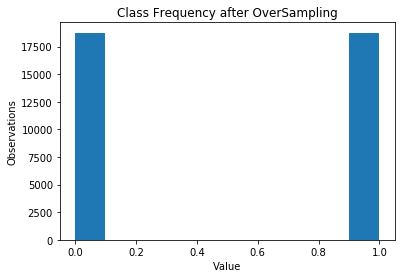

In [12]:
target_count = default.default.value_counts()
# Class count
default_class_0, default_class_1 = default_train.default.value_counts()

# Divide by class
default_class_0 = default_train[default_train['default'] == 0]
default_class_1 = default_train[default_train['default'] == 1]

default_class_1_over = default_class_1.sample(frac=target_count[0]/target_count[1], replace=True)
default_OverSampled = pd.concat([default_class_0, default_class_1_over], axis=0)

#Isolate the "default" variable into y and keep everythign else in X to use for predictions:
if 'default' in default_OverSampled:
    y_train = default_OverSampled['default'].values
    del default_OverSampled['default'] 
    X_train = default_OverSampled.values
    
if 'default' in default_test:
    y_test = default_test['default'].values
    del default_test['default'] 
    X_test = default_test.values

# use the previously fit scalines to transform the data after the over sampling
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)


print("Dimensions of final training features are " , X_train_scaled.shape)
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
plt.hist(y_train )
plt.xlabel('Value')
plt.ylabel('Observations')
plt.title('Class Frequency after OverSampling')
plt.show()

From above we can see that we now have 37k observations in our training set and the labels are balanced. We can now proceed with our reviewing various estimators and how they perform when classifying customer defaults.

### Comparing Different Classifier Models (Part 3)

For this particular problem we will compare three different models:

1. Support Vector Machine
2. K Nearest Neighbor 
3. Random Forest

To ensure we are chosing the right parameters of each model we will be using sklearns GridSearchCV with a 3 fold cross validation to identify the best estimators based on the F1 scores. This provides us a dynamic means of testing out many different model parameters.

We first train each model and look at some metrics for preliminary evaluation, then evaluate each model more thoroughly once all the models have been developed.

### Support Vector Machines

In [13]:
from sklearn.svm import SVC

svcEstimator = SVC()
cv = 3

#compare various values of C, kernels (rbf vs linear vs poly),decision_function_shape (ovo vs ovr) 
parameters = { 'C': [0.01, 0.1, 1]
              ,'kernel': ['rbf','linear','poly']
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
svcGridSearch = GridSearchCV(estimator=svcEstimator
                    , n_jobs=8 # jobs to run in parallel
                    , verbose=1 # low verbosity
                    , param_grid=parameters
                    , cv=cv # KFolds = 2
                    , scoring='f1')

#Perform hyperparameter search to find the best combination of parameters for our data
svcGridSearch.fit(X_train_scaled, y_train)
#Display the best estimator parameters
print("The best estimator based on F1 is ", svcGridSearch.best_estimator_)
svm_clf = svcGridSearch.best_estimator_ 

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=8)]: Done  27 out of  27 | elapsed:  9.4min finished


The best estimator based on F1 is  SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [25]:
from sklearn import metrics as mt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print(svm_clf)

clf = svm_clf

clf.fit(X_train_scaled,y_train)
yhat = clf.predict(X_test_scaled)
    
total_accuracy = mt.accuracy_score(y_test, yhat)
print ('Accuracy', total_accuracy)
conf = mt.confusion_matrix(y_test,yhat)
print('Confusion matrix:')
print(conf)
print('f1_score:', f1_score(y_test, yhat))
print('Precision:', precision_score(y_test, yhat))
print('Recall:', recall_score(y_test, yhat)) 

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy 0.7803565422132526
Confusion matrix:
[[3818  820]
 [ 486  822]]
f1_score: 0.5572881355932203
Precision: 0.5006090133982948
Recall: 0.6284403669724771


### K-Nearest Neighbor

In [15]:
from sklearn.neighbors import KNeighborsClassifier
svcEstimator = KNeighborsClassifier()
cv = 3

#compare various values of C, kernels (rbf vs linear vs poly),decision_function_shape (ovo vs ovr) 
parameters = {'n_neighbors': [3,5,7,11]}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
svcGridSearch = GridSearchCV(estimator=svcEstimator
                    , n_jobs=8 # jobs to run in parallel
                    , verbose=1 # low verbosity
                    , param_grid=parameters
                    , cv=cv # KFolds = 3
                    , scoring='accuracy')

svcGridSearch.fit(X_train_scaled, y_train)
print("The best estimator based on F1 is ", svcGridSearch.best_estimator_)
knn_clf = svcGridSearch.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=8)]: Done  10 out of  12 | elapsed:  2.7min remaining:   32.3s
[Parallel(n_jobs=8)]: Done  12 out of  12 | elapsed:  2.8min finished


The best estimator based on F1 is  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')


In [26]:
print(knn_clf)

clf = knn_clf

clf.fit(X_train_scaled,y_train)
yhat = clf.predict(X_test_scaled)
    
total_accuracy = mt.accuracy_score(y_test, yhat)
print ('Accuracy', total_accuracy)
conf = mt.confusion_matrix(y_test,yhat)
print('Confusion matrix:')
print(conf)
print('f1_score:', f1_score(y_test, yhat))
print('Precision:', precision_score(y_test, yhat))
print('Recall:', recall_score(y_test, yhat)) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
Accuracy 0.7028254288597376
Confusion matrix:
[[3442 1196]
 [ 571  737]]
f1_score: 0.45479790188213515
Precision: 0.3812726332126229
Recall: 0.5634556574923547


### Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
svcEstimator = RandomForestClassifier()
cv = 3

#compare various values of C, kernels (rbf vs linear vs poly),decision_function_shape (ovo vs ovr) 
parameters = {'n_estimators': [100,250,500]
             , 'max_depth': [5,25,50,100]}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
svcGridSearch = GridSearchCV(estimator=svcEstimator
                    , n_jobs=8 # jobs to run in parallel
                    , verbose=1 # low verbosity
                    , param_grid=parameters
                    , cv=cv # KFolds = 3
                    , scoring='accuracy')

svcGridSearch.fit(X_train_scaled, y_train)
print("The best estimator based on F1 is ", svcGridSearch.best_estimator_)
rf_clf = svcGridSearch.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed:  3.3min finished


The best estimator based on F1 is  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [23]:
clf = rf_clf

clf.fit(X_train_scaled,y_train)
yhat = clf.predict(X_test_scaled)
    
total_accuracy = mt.accuracy_score(y_test, yhat)
print ('Accuracy', total_accuracy)
conf = mt.confusion_matrix(y_test,yhat)
print('Confusion matrix:')
print(conf)
print('f1_score:', f1_score(y_test, yhat))
print('Precision:', precision_score(y_test, yhat))
print('Recall:', recall_score(y_test, yhat)) 

Accuracy 0.8227379751093172
Confusion matrix:
[[4291  347]
 [ 707  601]]
f1_score: 0.5328014184397164
Precision: 0.6339662447257384
Recall: 0.459480122324159


### Classifier Evaluation
In the following section we evaluate the different classifiers and determine the model that we would like to use going forward.

In [36]:
#get the predictions from the three models for evaluation
yhat_svm = svm_clf.predict(X_test_scaled)
yhat_knn = knn_clf.predict(X_test_scaled)
yhat_rf = rf_clf.predict(X_test_scaled)

print("SVM F1 Score ", f1_score(y_test, yhat_svm))
print("KNN F1 Score ", f1_score(y_test, yhat_knn))
print("KNN F1 Score ", f1_score(y_test, yhat_rf))


SVM F1 Score  0.5572881355932203
KNN F1 Score  0.45479790188213515
KNN F1 Score  0.5261744966442953


### Feature Importance

Continue rigorous detailed evaluation of different components

# Predicting Education Level from Credit History
The goal of these models is to try and classify a customers education by looking at there payment history.

### Modeling & Evaluation Considerations

Part 1)

One use for this suite of models is to apply marketing strategies for other products to these demographic groups if the customer does not provide the information.

The evaluation metric should again consider a balance between Recall and Precision. Low Recall again represents a missed opportunity to apply a more targeted strategy, and low Precision would result in the wrong strategy applied to a given prospect.

Applying the wrong strategy can be expected to decrease the credibility of the business in the customer's view, and may make the customer less likely to respond to other offers.

Since F1 considers both, we will choose it as the evaluation metric for this as well.

Part 2)

For this part of the analysis we have a similar class imbalance problem as what we had in our default example. However, in order to better understand the effects of this issue we chose not to re-balance this data. Our cross validation technique is the same as before. We split the data into training and test sets using an 80/20 split. Using the training data to train our models and evaluating on the remaining 20.

### Data Preperation - Education Classification Specific
Below we perform several steps that explain some of the data preparation tasks that are specific to the goal of classifying education.

In [9]:
#Create a separate dataset with only useful variables as identified in Lab1 and Mini-lab1.
default = df[['SEX','EDUCATION','MARRIAGE','AGE', 'default'
            ,'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5','PAY_6', "log_LIMIT_BAL"
            ,"log_PAY_AMT1","log_PAY_AMT2","log_PAY_AMT3","log_PAY_AMT4","log_PAY_AMT5"
            ,"log_PAY_AMT6", "log_BILL_AMT1","log_BILL_AMT2","log_BILL_AMT3",
             "log_BILL_AMT4","log_BILL_AMT5","log_BILL_AMT6"]]

# perform one-hot encoding of the categorical data "EDUCATION" and "MARRIAGE".
tmp_df_2 = pd.get_dummies(df.MARRIAGE,prefix='MARRIAGE')
educ = pd.concat((df,tmp_df_2),axis=1)
del educ['MARRIAGE']

from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'default' in educ:
    y = educ['EDUCATION'].values # get the labels we want
    del educ['EDUCATION'] # get rid of the class label
    X = educ.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 5
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=5, random_state=None, test_size=0.2, train_size=None)


In [12]:
from sklearn.preprocessing import StandardScaler

scl_obj = StandardScaler()

for train_indices, test_indices in cv_object.split(X,y): 
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
scl_obj.fit(X_train)

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test)

print("Dimensions of training features are " , X_train.shape)
print("Dimensions of training target are " , y_train.shape)
print("Dimensions of testing features are " , X_test.shape)
print("Dimensions of testing target are " , y_test.shape)

Dimensions of training features are  (24000, 38)
Dimensions of training target are  (24000,)
Dimensions of testing features are  (6000, 38)
Dimensions of testing target are  (6000,)


### Comparing Different Classifier Models

For this particular problem we will compare three different models:

1. Support Vector Machine
2. K Nearest Neighbor 
3. Random Forest

To ensure we are chosing the right parameters of each model we will be using sklearns GridSearchCV with a 3 fold cross validation to identify the best estimators based on the accuracy. 

### Support Vector Machines

In [15]:
# lets investigate SVMs on the data
from sklearn.svm import SVC
from sklearn import metrics as mt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# train the model
svm_clf = SVC(C=0.5, kernel='linear', degree=5, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('Accuracy:', acc )
print('Confusion matrix:')
print(conf)
print('classification_report:')
print(classification_report(y_test, y_hat))

Accuracy: 0.5338333333333334
Confusion matrix:
[[1029 1089    0    0]
 [ 655 2174    0    0]
 [ 173  794    0    0]
 [  19   67    0    0]]
classification_report:
             precision    recall  f1-score   support

          1       0.55      0.49      0.52      2118
          2       0.53      0.77      0.63      2829
          3       0.00      0.00      0.00       967
          4       0.00      0.00      0.00        86

avg / total       0.44      0.53      0.48      6000



C:\Users\bsnxw01\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 640x480 with 1 Axes>

### K-Nearest Neighbor

KNN accuracy 0.403
Confusion matrix:
[[ 955  998  158    7]
 [1204 1369  254    2]
 [ 408  465   94    0]
 [  34   38   14    0]]
classification_report:
             precision    recall  f1-score   support

          1       0.37      0.45      0.40      2118
          2       0.48      0.48      0.48      2829
          3       0.18      0.10      0.13       967
          4       0.00      0.00      0.00        86

avg / total       0.38      0.40      0.39      6000



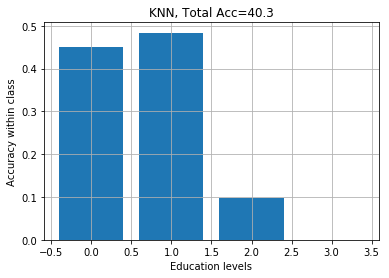

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics as mt


# get a handle to the classifier object, which defines the type
clf = KNeighborsClassifier(n_neighbors=3)

# now iterate through and get predictions, saved to the correct row in yhat
# NOTE: you can parallelize this using the cross_val_predict method
for train, test in cv_object.split(X,y):
    clf.fit(X[train],y[train])
    yhat = clf.predict(X[test])

total_accuracy = mt.accuracy_score(y_test, yhat)
print ('KNN accuracy', total_accuracy)
conf = mt.confusion_matrix(y_test,yhat)
print('Confusion matrix:')
print(conf)
print('classification_report:')
print(classification_report(y_test, yhat))  
plot_class_acc(y_test,yhat,title="KNN")

### Random Forest

Accuracy 0.4195
Confusion matrix:
[[ 738 1284   96    0]
 [ 978 1733  117    1]
 [ 319  602   46    0]
 [  27   54    5    0]]
classification_report:
             precision    recall  f1-score   support

          1       0.36      0.35      0.35      2118
          2       0.47      0.61      0.53      2829
          3       0.17      0.05      0.07       967
          4       0.00      0.00      0.00        86

avg / total       0.38      0.42      0.39      6000



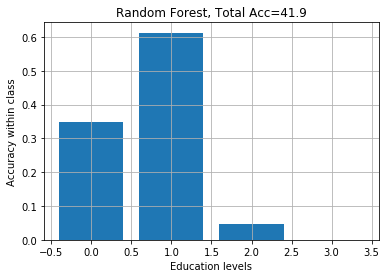

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

clf = RandomForestClassifier(max_depth=100, n_estimators=300, n_jobs=-1, oob_score=True)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv_object.split(X,y):
    clf.fit(X[train],y[train])
    yhat = clf.predict(X[test])
    
total_accuracy = mt.accuracy_score(y_test, yhat)
print ('Accuracy', total_accuracy)
conf = mt.confusion_matrix(y_test,yhat)
print('Confusion matrix:')
print(conf)
print('classification_report:')
print(classification_report(y_test, yhat))
plot_class_acc(y_test,yhat,title="Random Forest")

### Model Evaluation

### Feature Importance

# Model Deployment

# Exceptional Work